In [1]:
# reload lib in case of changes
import numpy as np
import torch
from torch import optim
import torch.functional as F
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from src.plots import plot_three_images
import torch.nn as nn

2025-02-04 17:12:14.546 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /Users/lorenzobenzoni/Documents/university/thesis/repo


In [2]:
%load_ext autoreload
%autoreload 2

# Load the Pretrained Convolutional Auto Encoder Model

In [2]:
path_file = '/Volumes/DataDisk/thesis/data_simulations/3/3.npz'

In [3]:
# Load the data
data = np.load(path_file)

burning_data, winds = data['burning_data'], data['winds']

In [4]:
# since for each simulation the winds in costant, for each cell and in time, we can take the first one

map_wind = lambda x: x[0, 0]

winds = np.array(list(map(map_wind, winds)))

winds = winds[:, :2]

In [5]:
# remove the first 10 timesteps since are difficult to autoencode

burning_data = burning_data[:, 10:]

In [6]:
shape = (200, 200)

In [7]:
from src.modeling.models import ConvAutoEncoder

In [8]:
# load the paramteres
device = torch.device('cpu')
model = ConvAutoEncoder(latent_dim=10, shape=(200, 200)).to(device)
model.load_state_dict(torch.load('/Users/lorenzobenzoni/Documents/university/thesis/repo/models/dataset_3/ConvAutoEncoder/v1.0.0/training_runs/1/weights.pth', weights_only=True))

<All keys matched successfully>

In [10]:
device = torch.device('mps')
model = model.to(device)

Let's plot one original and one reconstructed image to see how well the model is doing.

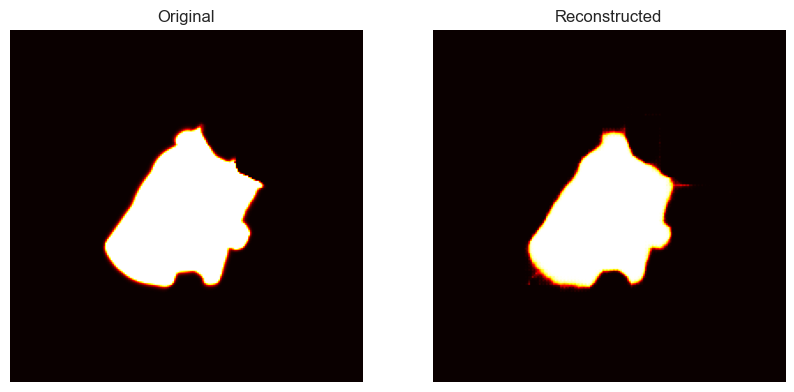

In [11]:
from src.plots import plot_two_images

model.eval()
input = burning_data[43]
id = 5
recon_input = model(torch.tensor(input).float().to(device))
recon_input = recon_input.cpu().detach().numpy()

plot_two_images(input[id], recon_input[id], 'Original', 'Reconstructed')

In [12]:
encoded = model.encode(torch.tensor(input).float().to(device))

In [18]:
from src.datasets.utils import coarse_map_with_convolution, upscale_map

coarse_input = coarse_map_with_convolution(input[id], 4, "mean")
upscaled = upscale_map(coarse_input, 4)

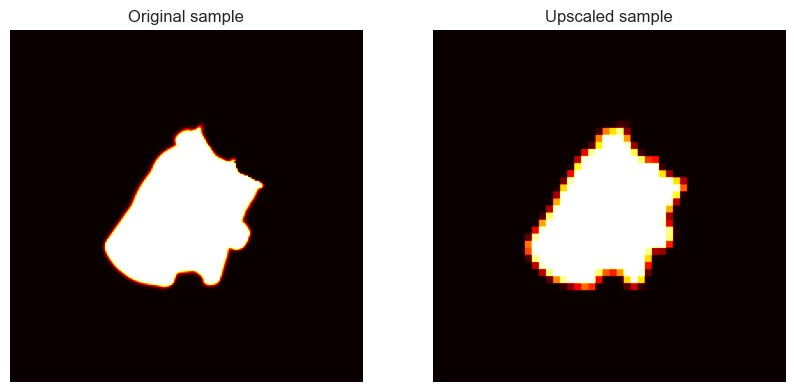

In [19]:
plot_two_images(input[id], upscaled, 'Original sample', 'Upscaled sample')

In [20]:
upscaled_t = torch.tensor(upscaled).float().to(device).unsqueeze(0)

upscaled_hat_t = model(upscaled_t)

upscaled_hat = upscaled_hat_t.cpu().detach().numpy().squeeze(0)

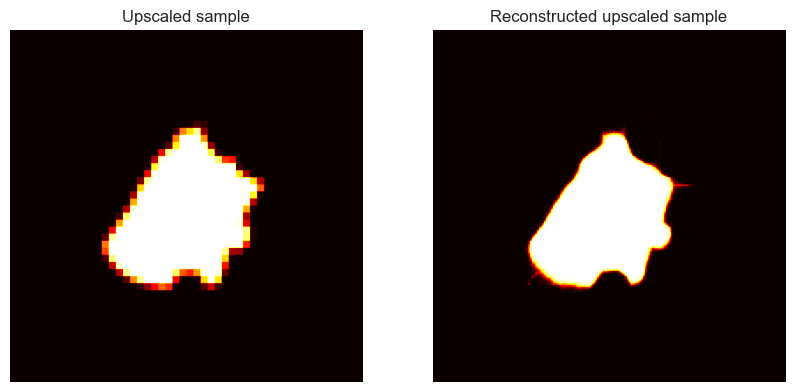

In [21]:
plot_two_images(upscaled, upscaled_hat, 'Upscaled sample', 'Reconstructed upscaled sample')

We can see that the convolutional autoencoder is able to reconstruct the image with a high degree of accuracy, like a super-resolution model.
This helps with the reconstruction of the dynamics.

In [22]:
data = burning_data

In [29]:
coarse_data_raw = np.load('/Users/lorenzobenzoni/Documents/university/thesis/repo/data/processed/3/real_coarse/coarse_4/3_coarse_4.npz')['burning_data']

In [30]:
coarse_data_raw = coarse_data_raw[:, 10:]

Now we try to take a sample out of the training set (the 48th episode) and see how well the model can reconstruct the space of the samples.

In [32]:
coarse_data = np.zeros_like(data)

for i in range(coarse_data_raw.shape[0]):
    for j in range(coarse_data_raw.shape[1]):
        coarse_data[i, j] = upscale_map(coarse_data_raw[i, j], 4)

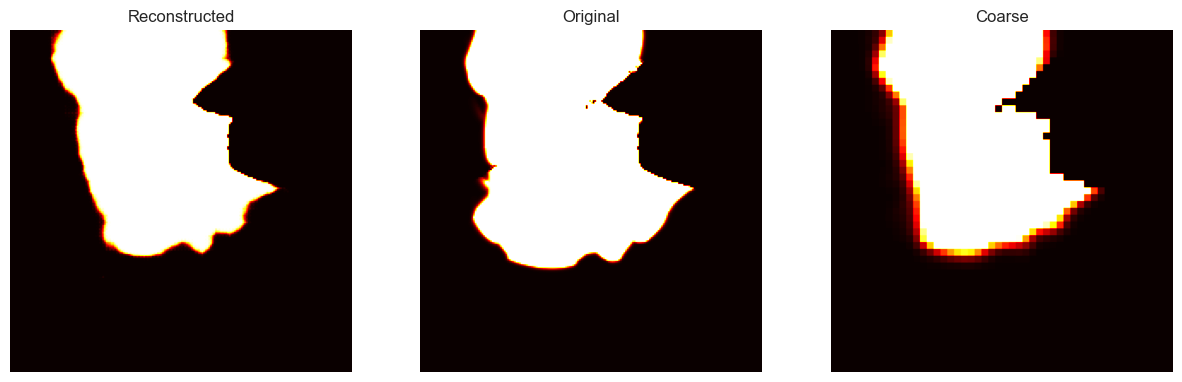

In [33]:
episode_id = 48

coarse_data_tensor = torch.tensor(coarse_data[episode_id], dtype=torch.float32).to(device)

encoded_coarse_t = model(coarse_data_tensor)
encoded_coarse = encoded_coarse_t.cpu().detach().numpy()

plot_three_images(encoded_coarse[44], burning_data[episode_id, 44], coarse_data[episode_id, 44], 'Reconstructed', 'Original', 'Coarse')

We can see that the reconstruction is not perfect, but it is quite good. Hopefully, this will help us to understand the dynamics of the system.

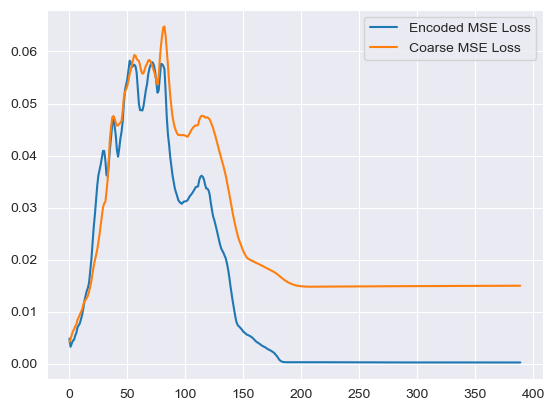

In [34]:
# Taking for example this episode, we plot for each timeframe the mse between the original and the reconstructed
episode_id = 40
mse = []
mse_coarse = []

coarse_data_tensor = torch.tensor(coarse_data[episode_id], dtype=torch.float32).to(device)

encoded_coarse_t = model(coarse_data_tensor)
encoded_coarse = encoded_coarse_t.cpu().detach().numpy()

for timestamp in range(coarse_data.shape[1]):
    mse.append(np.mean((encoded_coarse[timestamp] - burning_data[episode_id, timestamp])**2))
    mse_coarse.append(np.mean((coarse_data[episode_id, timestamp] - burning_data[episode_id, timestamp])**2))

plt.plot(mse, label='Encoded MSE Loss')
plt.plot(mse_coarse, label='Coarse MSE Loss')
plt.legend()
plt.show()

We can conclude, that on average, the HF model is able to better reconstruct the space.
So, we hope that the HF-ConvAutoEncoder model will be aple to use the latent variables in a useful way.

Instantiate the Encoder, the Decoder and load the parameters of the model.

In [11]:
from src.modeling.models import EncoderRNN, AttnDecoderRNN

encoder = EncoderRNN(12, 140, dropout_p=0.1)
decoder = AttnDecoderRNN(10, 140, 10, dropout_p=0.1)

In [36]:
encoder.load_state_dict(torch.load('/Users/lorenzobenzoni/Documents/university/thesis/repo/models/dataset_3/Seq2SeqMultiFidelity/v1.0.0/training_runs/pytorch/2/encoder_multi_fid_20_80_20_coarse.pth', map_location=torch.device('cpu'), weights_only=True))
decoder.load_state_dict(torch.load('/Users/lorenzobenzoni/Documents/university/thesis/repo/models/dataset_3/Seq2SeqMultiFidelity/v1.0.0/training_runs/pytorch/2/decoder_multi_fid_20_80_20_coarse.pth', map_location=torch.device('cpu'), weights_only=True))

<All keys matched successfully>

In [37]:
from src.datasets.utils import _encode_data

episode_id = 49

burning_data_episode = torch.tensor(burning_data[episode_id]).float()
coarse_data_episode = torch.tensor(coarse_data[episode_id]).float()

burning_data_episode_encoded = _encode_data(burning_data_episode, model, shape=(200, 200)).cpu().detach().numpy()
coarse_data_episode_encoded = _encode_data(coarse_data_episode, model, shape=(200, 200)).cpu().detach().numpy()

In [38]:
from src.datasets.dataset import SequenceDatasetMultiFidelity

burning_data_episode_encoded = burning_data_episode_encoded[np.newaxis]
coarse_data_episode_encoded = coarse_data_episode_encoded[np.newaxis]


dataset = SequenceDatasetMultiFidelity(
    burning_data_episode_encoded,
    coarse_data_episode_encoded,
    winds,
    input_len=10,
    output_len=80,
    hop=0,
    n_samples=390,
    n_simulations=1
)

dataloader = DataLoader(dataset, batch_size=200, shuffle=False)

In [51]:
with torch.no_grad():
    for (X_batch, _), (y_batch, y_batch_coarse) in dataloader:
        encoder_outputs, encoder_hidden = encoder(X_batch)
        decoder_outputs, _, attentions = decoder(encoder_outputs, encoder_hidden, y_batch_coarse)
        break

In [52]:
starting_point = 0

X_batch = model.decode(X_batch[starting_point, :, :10])
y_batch = model.decode(y_batch[starting_point, :, :10])
decoder_outputs = model.decode(decoder_outputs[starting_point, :, :10])
y_batch_coarse = model.decode(y_batch_coarse[starting_point, :, :10])

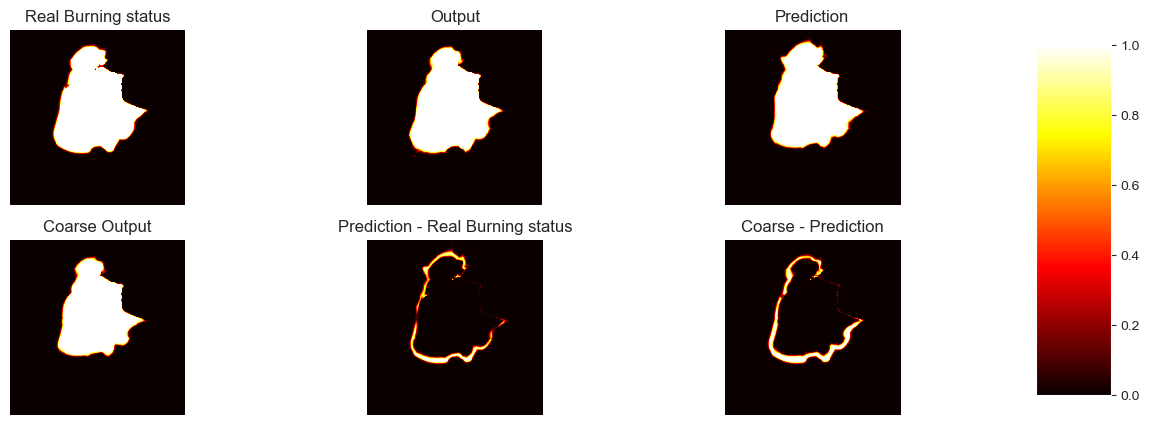

In [54]:
id = 13

fig, axs = plt.subplots(2, 3, figsize=(15, 5))

# im = axs[0, 0].imshow(X_batch[4].cpu().detach().numpy(), cmap='hot',)
# axs[0, 0].set_title('Input')
# axs[0, 0].axis('off')

im = axs[0, 0].imshow(burning_data_episode[id + 10 + starting_point] , cmap='hot',)
axs[0, 0].set_title('Real Burning status')
axs[0, 0].axis('off')

im = axs[0, 1].imshow(y_batch[id].cpu().detach().numpy(), cmap='hot',)
axs[0, 1].set_title('Output')
axs[0, 1].axis('off')

im = axs[0, 2].imshow(decoder_outputs[id].cpu().detach().numpy(), cmap='hot',)
axs[0, 2].set_title('Prediction')
axs[0, 2].axis('off')

im = axs[1, 0].imshow(y_batch_coarse[id].cpu().detach().numpy(), cmap='hot',)

axs[1, 0].set_title('Coarse Output')

axs[1, 0].axis('off')

im = axs[1, 1].imshow(np.abs(decoder_outputs[id].cpu().detach().numpy() - burning_data_episode[id + 10 + starting_point].numpy()), cmap='hot')

axs[1, 1].set_title('Prediction - Real Burning status')

axs[1, 1].axis('off')

im = axs[1, 2].imshow(np.abs(y_batch_coarse[id].cpu().detach().numpy() - burning_data_episode[id + 10 + starting_point].numpy()), cmap='hot',)

axs[1, 2].set_title('Coarse - Prediction')

axs[1, 2].axis('off')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

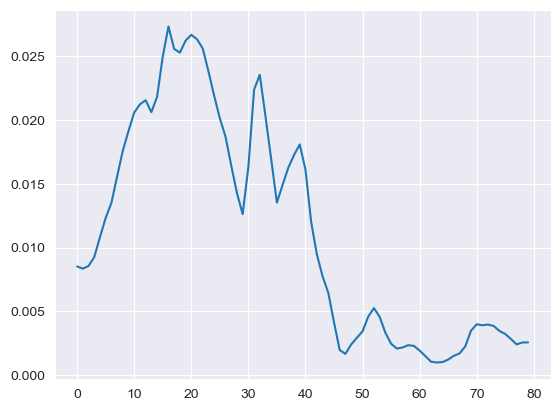

In [55]:
# y_batch_coarse = y_batch_coarse.to(torch.device('mps'))
mses = []
for i in range(80):
    mse = nn.MSELoss()(decoder_outputs[i], y_batch[i])
    mses.append(mse.item())

plt.plot(mses)

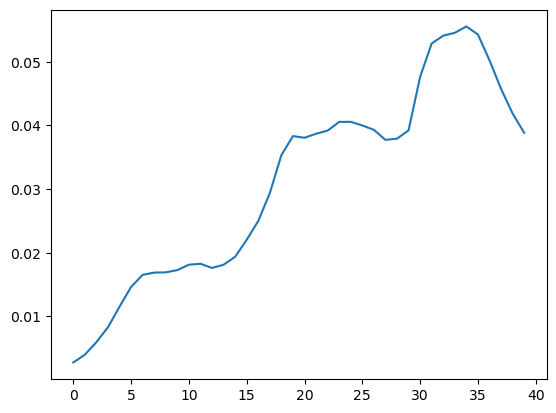

In [62]:
# y_batch_coarse = y_batch_coarse.to(torch.device('mps'))
mses = []
for i in range(40):
    mse = nn.MSELoss()(y_batch_coarse[i], y_batch[i])
    mses.append(mse.item())

plt.plot(mses)

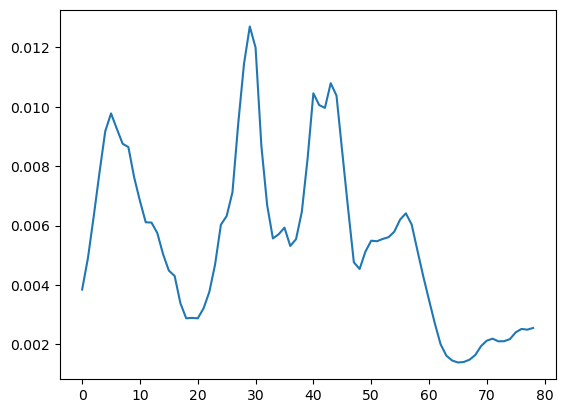

In [63]:
mses = []
for i in range(79):
    mse = nn.MSELoss()(burning_data_episode[i + 10], decoder_outputs[i])
    mses.append(mse.item())

plt.plot(mses)

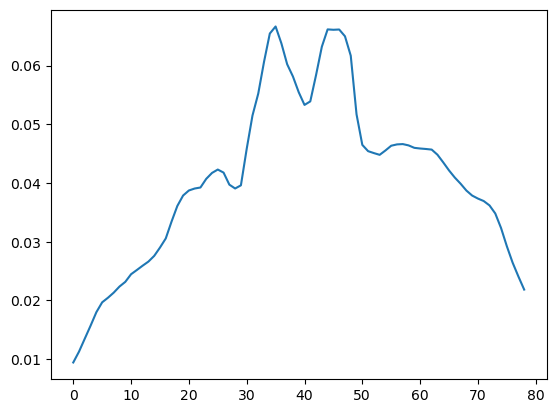

In [64]:
mses = []
for i in range(79):
    mse = nn.MSELoss()(burning_data_episode[i + 10], y_batch_coarse[i])
    mses.append(mse.item())

plt.plot(mses)

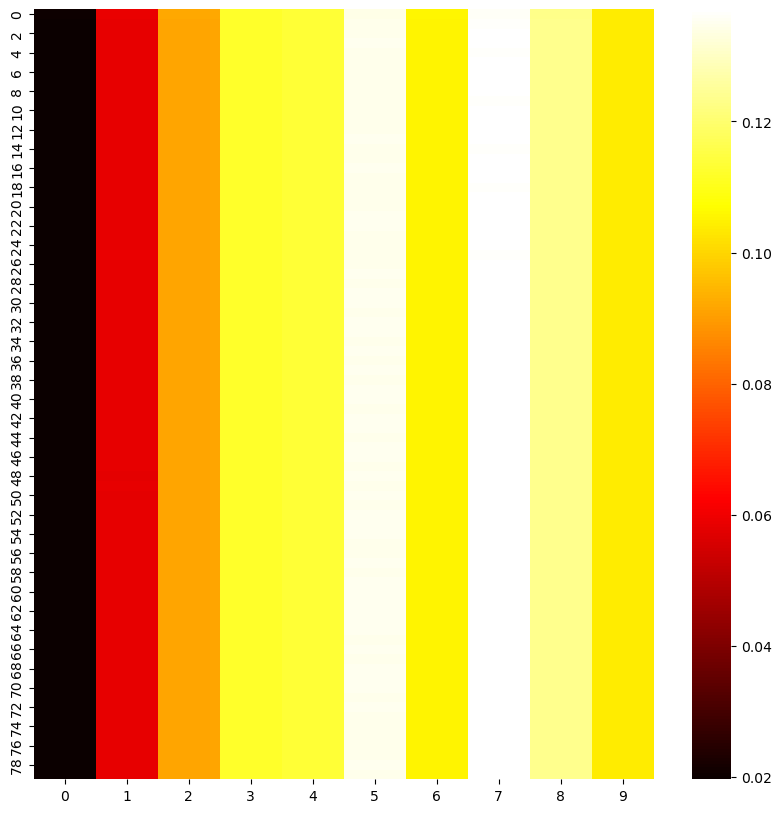

In [65]:
# plot the attention as a heatmap
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(attentions.cpu().detach().numpy()[45], ax=ax, cmap='hot')
plt.show()


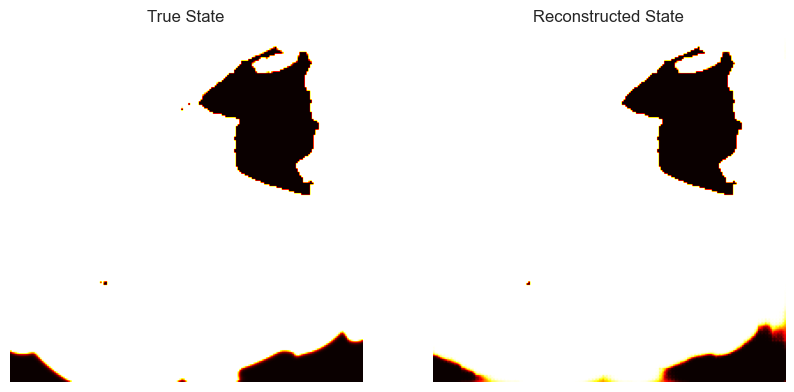

In [56]:
# create a video
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax_true, ax_recon = axes

# Titles
ax_true.set_title("True State")
ax_recon.set_title("Reconstructed State")


# Initialize the images
img_true = ax_true.imshow(burning_data_episode[10].numpy(), cmap="hot", vmin=0, vmax=1)
img_recon = ax_recon.imshow(decoder_outputs[0].cpu().detach().numpy(), cmap="hot", vmin=0, vmax=1)

# Remove axes for a cleaner look
for ax in axes:
    ax.axis("off")

# Update function for animation
def update(frame):
    img_true.set_data(burning_data_episode[frame + 10].numpy())
    img_recon.set_data(decoder_outputs[frame].cpu().detach().numpy())
    return img_true, img_recon

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=79, interval=1, blit=True)

# To save as a video (optional)
ani.save("4.multi_fidelity_simulation_49_coarse_20.mp4", writer="ffmpeg", fps=10)